In [ ]:
import pandas as pd
import wrds
conn=wrds.Connection()

Enter your WRDS username [gujiajun]: jiajung2
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  n


You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Retrieve S&P 500 data
sp500 = conn.raw_sql("""
                        select a.*, b.date, b.ret, b.prc, b.vol, b.shrout
                        from crsp.msp500list as a,
                        crsp.msf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='01/01/2019'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])

# Retrieve additional descriptive data
mse = conn.raw_sql("""
                        select comnam, ncusip, namedt, nameendt,
                        permno, shrcd, exchcd, hsiccd, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# Handle missing end dates by setting them to today
mse['nameendt'] = mse['nameendt'].fillna(pd.to_datetime('today'))

# Merge S&P 500 data with descriptive data
sp500_full = pd.merge(sp500, mse, how='left', on='permno')

# Impose date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date >= sp500_full.namedt) &
                            (sp500_full.date <= sp500_full.nameendt)]

# Ensure data is sorted by date for rolling calculations
sp500_full = sp500_full.sort_values(by=['permno', 'date']).reset_index(drop=True)


In [ ]:
sp500_full['Market_Cap'] = sp500_full['prc'].abs() * sp500_full['shrout']  # Market Capitalization
sp500_full['Log_Market_Cap'] = np.log1p(sp500_full['Market_Cap'])
sp500_full['Momentum'] = sp500_full.groupby('permno')['prc'].pct_change(periods=4)  # 12-month momentum
sp500_full['Price_Based_Factors'] = sp500_full['prc'].pct_change()  # Simple price-based return factor
sp500_full['Momentum_Change'] = sp500_full['Momentum'] - sp500_full['Momentum'].shift(1)
sp500_full['Momentum_MA'] = sp500_full.groupby('permno')['Momentum'].transform(lambda x: x.rolling(window=10).mean())
sp500_full['Amihud_Illiquidity'] = sp500_full['prc'].abs() / sp500_full['vol'] # Amihud Illiquidity
sp500_full['Turnover_Ratio'] = sp500_full['vol'] / sp500_full['shrout'] # Turnover Ratio
sp500_full['Rolling_Volatility'] = sp500_full.groupby('permno')['ret'].transform(lambda x: x.rolling(window=20).std()) # Rolling Volatility
sp500_full['High_Low_Spread'] = sp500_full['prc'] - sp500_full.groupby('permno')['prc'].transform('min') # High-Low Spread
# RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

sp500_full['RSI'] = sp500_full.groupby('permno')['prc'].transform(lambda x: compute_rsi(x))
sp500_full['Price_MA_20'] = sp500_full.groupby('permno')['prc'].transform(lambda x: x.rolling(window=20).mean()) # Moving Averages
# Interaction Features
sp500_full['Momentum_vs_MarketCap'] = sp500_full['Momentum'] * sp500_full['Log_Market_Cap']
sp500_full['Volatility_vs_Turnover'] = sp500_full['Rolling_Volatility'] * sp500_full['Turnover_Ratio']
# Handle missing or infinite values
sp500_full.replace([np.inf, -np.inf], np.nan, inplace=True)
sp500_full['Momentum_Liquidity'] = sp500_full['Momentum'] * sp500_full['Amihud_Illiquidity']
sp500_full['Volatility_Turnover'] = sp500_full['Rolling_Volatility'] * sp500_full['Turnover_Ratio']
sp500_full['MarketCap_Adjusted_Momentum'] = sp500_full['Momentum'] / sp500_full['Market_Cap']
sp500_full['Momentum_MA_Deviation'] = sp500_full['Momentum'] - sp500_full['Price_MA_20']
sp500_full['Normalized_High_Low'] = sp500_full['High_Low_Spread'] / sp500_full['prc']
sp500_full['Momentum_RSI'] = sp500_full['Momentum'] * sp500_full['RSI']
sp500_full['Smoothed_Return'] = sp500_full['Price_Based_Factors'].rolling(window=10).mean()
sp500_full['Volatility_Adjusted_Return'] = sp500_full['Price_Based_Factors'] / sp500_full['Rolling_Volatility']
sp500_full['Volatility_Slope'] = sp500_full['Rolling_Volatility'].diff() / sp500_full['date'].diff().dt.days
sp500_full['Volatility_Dynamics'] = sp500_full['Rolling_Volatility'] * sp500_full['Volatility_Slope']
sp500_full['Liquidity_Stress'] = (
    sp500_full['Turnover_Ratio'] * abs(sp500_full['Price_Based_Factors']) / sp500_full['Market_Cap']
)
sp500_full['Trend_Strength'] = (
    (sp500_full['Momentum'] - sp500_full['Price_MA_20']) * sp500_full['RSI']
)
sp500_full['Risk_Adjusted_Momentum'] = (
    sp500_full['Momentum'] * sp500_full['Volatility_vs_Turnover'] / sp500_full['Rolling_Volatility']
)
sp500_full['Abnormal_Behavior'] = (
    sp500_full['Momentum'] * sp500_full['High_Low_Spread'] - sp500_full['RSI'] * sp500_full['Amihud_Illiquidity']
)
sp500_full['Mean_Reversion'] = (
    (sp500_full['prc'] - sp500_full['Price_MA_20']) / sp500_full['Rolling_Volatility']
)

sp500_full['Short_Momentum'] = sp500_full['prc'].pct_change(periods=20)
sp500_full['Long_Momentum'] = sp500_full['prc'].pct_change(periods=30)
sp500_full['Multi_Period_Momentum'] = sp500_full['Short_Momentum'] * sp500_full['Long_Momentum']

In [ ]:
sp500_full.tail()

,permno,start,ending,date,ret,prc,vol,shrout,comnam,ncusip,...,Volatility_Slope,Volatility_Dynamics,Liquidity_Stress,Trend_Strength,Risk_Adjusted_Momentum,Abnormal_Behavior,Mean_Reversion,Short_Momentum,Long_Momentum,Multi_Period_Momentum
30252,93436,2020-12-21,2023-12-29,2023-08-31,-0.034962,258.07999,25029170.0,3173994.0,TESLA INC,88160R10,...,-0.000020,-0.000004,3.365747e-10,-14705.874561,4.500287,76.985665,-906.092774,-0.755786,-0.617942,0.467032
30253,93436,2020-12-21,2023-12-29,2023-09-29,-0.030456,250.22000,24395440.0,3179000.0,TESLA INC,88160R10,...,-0.000057,-0.000012,2.938145e-10,-7576.740146,1.741904,28.836584,-784.366061,-0.732876,-0.625380,0.458326
30254,93436,2020-12-21,2023-12-29,2023-10-31,-0.197346,200.84000,25905681.0,3178921.0,TESLA INC,88160R10,...,0.000140,0.000029,2.518920e-09,-15747.059284,-1.896822,-18.076586,-843.496023,-0.769263,-0.716903,0.551488
30255,93436,2020-12-21,2023-12-29,2023-11-30,0.195379,240.08000,26395792.0,3178921.0,TESLA INC,88160R10,...,-0.000077,-0.000016,2.125681e-09,-15904.982153,-0.849184,-11.955761,-461.388654,-0.777209,-0.616007,0.478766
30256,93436,2020-12-21,2023-12-29,2023-12-29,0.034988,248.48000,22852106.0,3178921.0,TESLA INC,88160R10,...,-0.000169,-0.000034,3.184187e-10,-15939.232969,-0.267401,-4.661445,-277.217665,-0.714640,-0.634427,0.453387


In [ ]:
sp500_full.head()

,permno,start,ending,date,ret,prc,vol,shrout,comnam,ncusip,...,Volatility_Slope,Volatility_Dynamics,Liquidity_Stress,Trend_Strength,Risk_Adjusted_Momentum,Abnormal_Behavior,Mean_Reversion,Short_Momentum,Long_Momentum,Multi_Period_Momentum
0,10104,1989-08-03,2023-12-29,2019-01-31,0.116722,50.23,3248083.0,3588919.0,ORACLE CORP,68389X10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10104,1989-08-03,2023-12-29,2019-02-28,0.037826,52.13,2578429.0,3588919.0,ORACLE CORP,68389X10,...,NaN,NaN,1.452548e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10104,1989-08-03,2023-12-29,2019-03-29,0.030309,53.71,3706972.0,3417654.0,ORACLE CORP,68389X10,...,NaN,NaN,1.790925e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10104,1989-08-03,2023-12-29,2019-04-30,0.034631,55.33,1935070.0,3417654.0,ORACLE CORP,68389X10,...,NaN,NaN,9.031080e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10104,1989-08-03,2023-12-29,2019-05-31,-0.085487,50.60,2400930.0,3417654.0,ORACLE CORP,68389X10,...,NaN,NaN,3.472748e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sp500_full.columns

Index(['permno', 'start', 'ending', 'date', 'ret', 'prc', 'vol', 'shrout',
       'comnam', 'ncusip', 'namedt', 'nameendt', 'shrcd', 'exchcd', 'hsiccd',
       'ticker', 'Market_Cap', 'Log_Market_Cap', 'Momentum',
       'Price_Based_Factors', 'Momentum_Change', 'Momentum_MA',
       'Amihud_Illiquidity', 'Turnover_Ratio', 'Rolling_Volatility',
       'High_Low_Spread', 'RSI', 'Price_MA_20', 'Momentum_vs_MarketCap',
       'Volatility_vs_Turnover', 'Momentum_Liquidity', 'Volatility_Turnover',
       'MarketCap_Adjusted_Momentum', 'Momentum_MA_Deviation',
       'Normalized_High_Low', 'Momentum_RSI', 'Smoothed_Return',
       'Volatility_Adjusted_Return', 'Volatility_Slope', 'Volatility_Dynamics',
       'Liquidity_Stress', 'Trend_Strength', 'Risk_Adjusted_Momentum',
       'Abnormal_Behavior', 'Mean_Reversion', 'Short_Momentum',
       'Long_Momentum', 'Multi_Period_Momentum'],
      dtype='object')

In [ ]:
# Columns to fill NaN values
columns_to_fill = [
    'Rolling_Volatility', 'High_Low_Spread', 'RSI', 'Price_MA_20', 'Momentum_vs_MarketCap',
    'Volatility_vs_Turnover', 'Momentum', 'Momentum_Change', 'Momentum_MA',
    'Momentum_Liquidity', 'Volatility_Turnover', 'MarketCap_Adjusted_Momentum',
    'Momentum_MA_Deviation', 'Normalized_High_Low', 'Momentum_RSI', 'Smoothed_Return',
    'Volatility_Adjusted_Return', 'Volatility_Slope', 'Volatility_Dynamics',
    'Liquidity_Stress', 'Trend_Strength', 'Risk_Adjusted_Momentum', 'Abnormal_Behavior',
    'Mean_Reversion', 'Short_Momentum', 'Long_Momentum', 'Multi_Period_Momentum'
]

# Fill missing values using group-based forward fill for specified columns
for col in columns_to_fill:
    if col in sp500_full.columns:
        sp500_full[col] = sp500_full.groupby('permno')[col].transform(lambda x: x.fillna(method='ffill'))

# Fill remaining NaN values in the dataset with 0
sp500_full = sp500_full.fillna(0)


/var/folders/gf/ml7dm8wn2qn2k77q3vczgzw80000gn/T/ipykernel_68118/3684841682.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500_full[col] = sp500_full.groupby('permno')[col].transform(lambda x: x.fillna(method='ffill'))


In [ ]:
# Check if there are any remaining NaN values
print(sp500_full.isnull().sum())


permno                         0
start                          0
ending                         0
date                           0
ret                            0
prc                            0
vol                            0
shrout                         0
comnam                         0
ncusip                         0
namedt                         0
nameendt                       0
shrcd                          0
exchcd                         0
hsiccd                         0
ticker                         0
Market_Cap                     0
Log_Market_Cap                 0
Momentum                       0
Price_Based_Factors            0
Momentum_Change                0
Momentum_MA                    0
Amihud_Illiquidity             0
Turnover_Ratio                 0
Rolling_Volatility             0
High_Low_Spread                0
RSI                            0
Price_MA_20                    0
Momentum_vs_MarketCap          0
Volatility_vs_Turnover         0
Momentum_L

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.80607e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Forecasting Results:
Linear Regression    MSE: 0.00169, R²: 0.79923
Ridge Regression     MSE: 0.00179, R²: 0.78659
Random Forest        MSE: 0.00024, R²: 0.97150
Gradient Boosting    MSE: 0.00013, R²: 0.98500


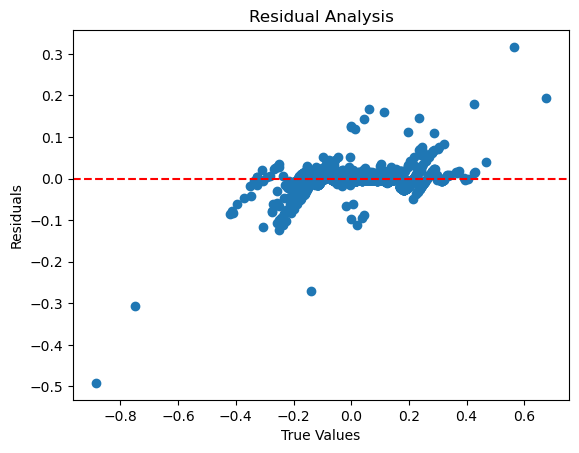

In [ ]:
# Before we adjust the factor
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
final_features = [
    'Market_Cap', 'Momentum', 'Price_Based_Factors', 'Momentum_Change',
    'Momentum_MA', 'Log_Market_Cap', 'Amihud_Illiquidity', 'Turnover_Ratio',
    'Rolling_Volatility', 'High_Low_Spread', 'RSI', 'Price_MA_20',
    'Momentum_vs_MarketCap', 'Volatility_vs_Turnover', 'Momentum_Liquidity',
    'Volatility_Turnover', 'MarketCap_Adjusted_Momentum', 'Momentum_MA_Deviation',
    'Normalized_High_Low', 'Momentum_RSI', 'Smoothed_Return',
    'Volatility_Adjusted_Return', 'Volatility_Slope', 'Volatility_Dynamics',
    'Liquidity_Stress', 'Trend_Strength', 'Risk_Adjusted_Momentum',
    'Abnormal_Behavior', 'Mean_Reversion', 'Short_Momentum', 'Long_Momentum',
    'Multi_Period_Momentum'
]
# Train-Test Split
sp500_full = sp500_full.sort_values(by='date')
split_index = int(len(sp500_full) * 0.8)
train_data = sp500_full.iloc[:split_index]
test_data = sp500_full.iloc[split_index:]

X_train = train_data[final_features]
y_train = train_data['ret']
X_test = test_data[final_features]
y_test = test_data['ret']

# Ensure finite values in X and y
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

# --- Model Evaluation ---
forecasting_results = {}

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)
forecasting_results["Linear Regression"] = {
    "MSE": mean_squared_error(y_test, y_pred_lr),
    "R²": r2_score(y_test, y_pred_lr)
}

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
forecasting_results["Ridge Regression"] = {
    "MSE": mean_squared_error(y_test, y_pred_ridge),
    "R²": r2_score(y_test, y_pred_ridge)
}

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=5, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
forecasting_results["Random Forest"] = {
    "MSE": mean_squared_error(y_test, y_pred_rf),
    "R²": r2_score(y_test, y_pred_rf)
}

# Gradient Boosting
gbr_model = GradientBoostingRegressor(
    n_estimators=100, max_depth=3, random_state=42
)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
forecasting_results["Gradient Boosting"] = {
    "MSE": mean_squared_error(y_test, y_pred_gbr),
    "R²": r2_score(y_test, y_pred_gbr)
}

# Display Results
print("\nForecasting Results:")
for model_name, metrics in forecasting_results.items():
    print(f"{model_name:20} MSE: {metrics['MSE']:.5f}, R²: {metrics['R²']:.5f}")

# Residual Analysis
y_pred_test = rf_model.predict(X_test)
residuals = y_test - y_pred_test
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()


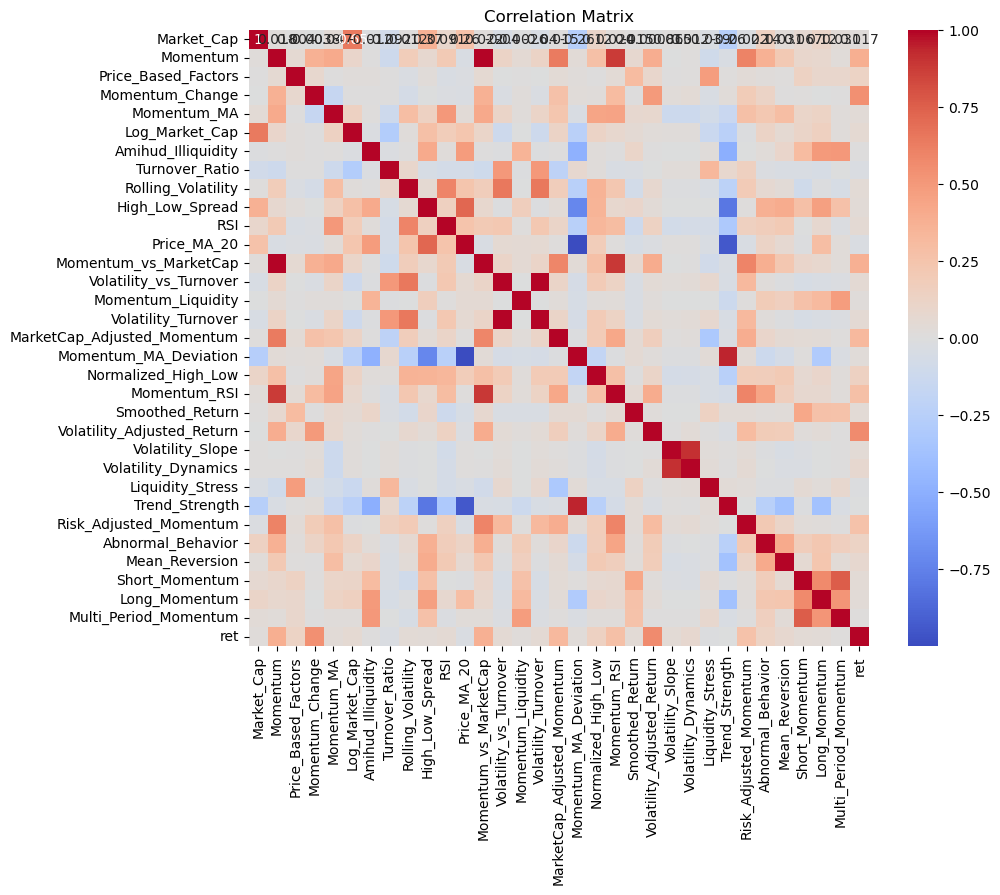

                        Feature  Importance
2           Price_Based_Factors    0.920377
1                      Momentum    0.029131
23          Volatility_Dynamics    0.015339
24             Liquidity_Stress    0.009102
3               Momentum_Change    0.008202
7                Turnover_Ratio    0.007443
12        Momentum_vs_MarketCap    0.004429
21   Volatility_Adjusted_Return    0.001368
31        Multi_Period_Momentum    0.000680
4                   Momentum_MA    0.000676
29               Short_Momentum    0.000607
20              Smoothed_Return    0.000391
5                Log_Market_Cap    0.000389
14           Momentum_Liquidity    0.000308
18          Normalized_High_Low    0.000263
19                 Momentum_RSI    0.000196
22             Volatility_Slope    0.000187
16  MarketCap_Adjusted_Momentum    0.000173
30                Long_Momentum    0.000172
10                          RSI    0.000143
6            Amihud_Illiquidity    0.000065
9               High_Low_Spread 

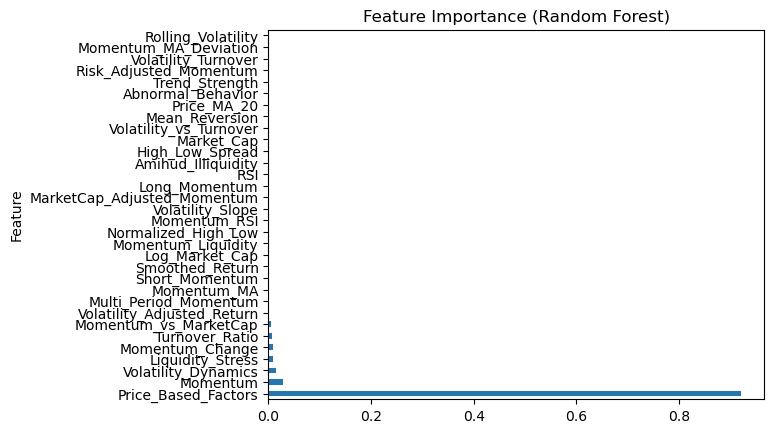

In [ ]:
# Correlation table with all factor included
import seaborn as sns
# Correlation matrix for features and target
correlation_matrix = train_data[final_features + ['ret']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature importance for Random Forest
rf_feature_importances = pd.DataFrame({
    'Feature': final_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(rf_feature_importances)

# Plot feature importances
rf_feature_importances.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance (Random Forest)")
plt.show()


In [ ]:
# First layer of filtering, filter out the x variable that have greater than 0.1 correlation with y variable

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'sp500_full' is your dataframe
# Compute correlation matrix
corr_matrix = sp500_full[final_features + ['ret']].corr()

# Get correlation with the target variable 'ret'
corr_with_target = corr_matrix['ret'].abs().sort_values(ascending=False)

# Define a threshold for correlation with target (e.g., below 0.1)
low_corr_features = corr_with_target[corr_with_target < 0.1].index.tolist()

# Filter out features with low correlation with the target variable
filtered_features = [feature for feature in final_features if feature not in low_corr_features]

print(f"Selected Features (Low Correlation with Target): {low_corr_features}")
print(f"Filtered Features: {filtered_features}")


Selected Features (Low Correlation with Target): ['Volatility_Dynamics', 'Mean_Reversion', 'Liquidity_Stress', 'RSI', 'Log_Market_Cap', 'Volatility_Slope', 'Turnover_Ratio', 'Rolling_Volatility', 'Short_Momentum', 'High_Low_Spread', 'Smoothed_Return', 'Long_Momentum', 'Momentum_MA', 'Market_Cap', 'Momentum_Liquidity', 'Multi_Period_Momentum', 'Trend_Strength', 'Momentum_MA_Deviation', 'Price_MA_20', 'Amihud_Illiquidity', 'Volatility_Turnover', 'Volatility_vs_Turnover']
Filtered Features: ['Momentum', 'Price_Based_Factors', 'Momentum_Change', 'Momentum_vs_MarketCap', 'MarketCap_Adjusted_Momentum', 'Normalized_High_Low', 'Momentum_RSI', 'Volatility_Adjusted_Return', 'Risk_Adjusted_Momentum', 'Abnormal_Behavior']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.80625e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Forecasting Results:
Linear Regression    MSE: 0.00681, R²: 0.18827
Ridge Regression     MSE: 0.00682, R²: 0.18652
Random Forest        MSE: 0.00654, R²: 0.21998
Gradient Boosting    MSE: 0.00499, R²: 0.40485


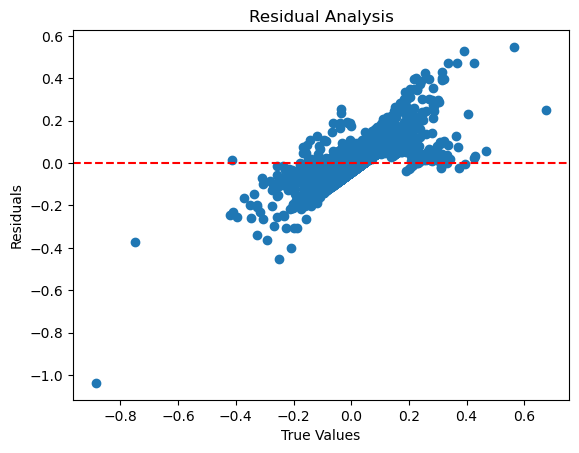

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
final_features = ['Volatility_Dynamics', 'Mean_Reversion', 'Liquidity_Stress', 'RSI', 'Log_Market_Cap', 'Volatility_Slope', 'Turnover_Ratio', 'Rolling_Volatility', 'Short_Momentum', 'High_Low_Spread', 'Smoothed_Return', 'Long_Momentum', 'Momentum_MA', 'Market_Cap', 'Momentum_Liquidity', 'Multi_Period_Momentum', 'Trend_Strength', 'Momentum_MA_Deviation', 'Price_MA_20', 'Amihud_Illiquidity', 'Volatility_Turnover', 'Volatility_vs_Turnover']

# Train-Test Split
sp500_full = sp500_full.sort_values(by='date')
split_index = int(len(sp500_full) * 0.8)
train_data = sp500_full.iloc[:split_index]
test_data = sp500_full.iloc[split_index:]

X_train = train_data[final_features]
y_train = train_data['ret']
X_test = test_data[final_features]
y_test = test_data['ret']

# Ensure finite values in X and y
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

# --- Model Evaluation ---
forecasting_results = {}

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)
forecasting_results["Linear Regression"] = {
    "MSE": mean_squared_error(y_test, y_pred_lr),
    "R²": r2_score(y_test, y_pred_lr)
}

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
forecasting_results["Ridge Regression"] = {
    "MSE": mean_squared_error(y_test, y_pred_ridge),
    "R²": r2_score(y_test, y_pred_ridge)
}

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=5, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
forecasting_results["Random Forest"] = {
    "MSE": mean_squared_error(y_test, y_pred_rf),
    "R²": r2_score(y_test, y_pred_rf)
}

# Gradient Boosting
gbr_model = GradientBoostingRegressor(
    n_estimators=100, max_depth=3, random_state=42
)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
forecasting_results["Gradient Boosting"] = {
    "MSE": mean_squared_error(y_test, y_pred_gbr),
    "R²": r2_score(y_test, y_pred_gbr)
}

# Display Results
print("\nForecasting Results:")
for model_name, metrics in forecasting_results.items():
    print(f"{model_name:20} MSE: {metrics['MSE']:.5f}, R²: {metrics['R²']:.5f}")

# Residual Analysis
y_pred_test = rf_model.predict(X_test)
residuals = y_test - y_pred_test
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()


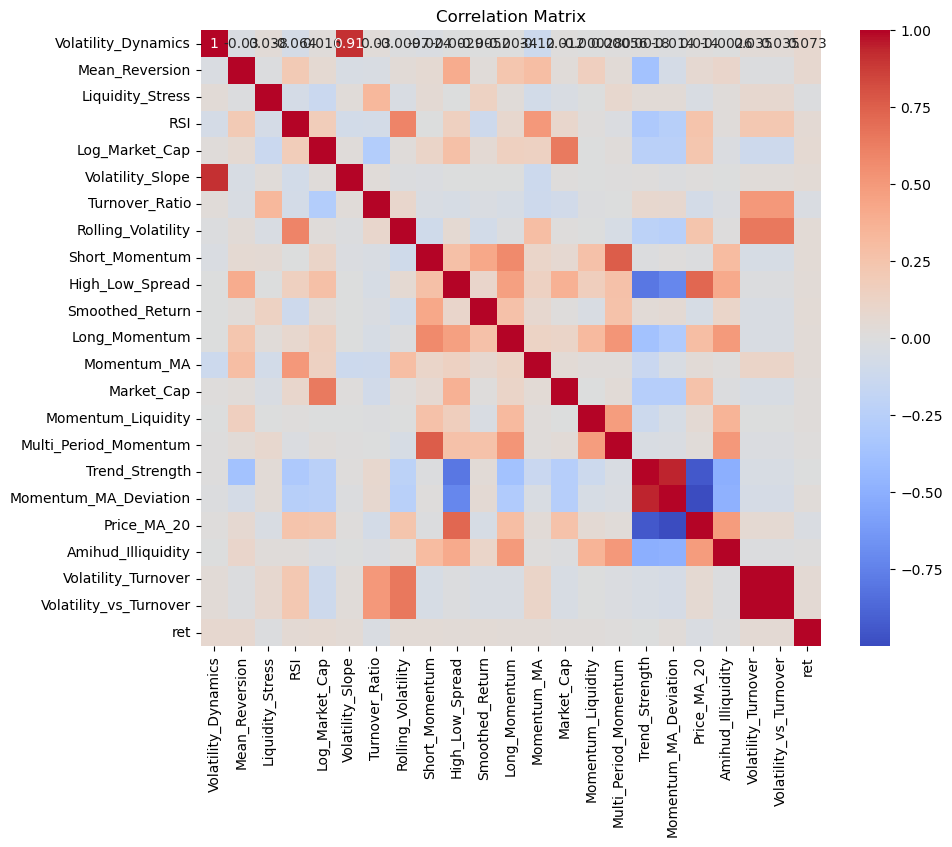

                   Feature  Importance
14      Momentum_Liquidity    0.354845
9          High_Low_Spread    0.181247
0      Volatility_Dynamics    0.170321
2         Liquidity_Stress    0.072441
5         Volatility_Slope    0.067259
6           Turnover_Ratio    0.067151
12             Momentum_MA    0.030975
3                      RSI    0.013466
10         Smoothed_Return    0.010995
1           Mean_Reversion    0.007192
19      Amihud_Illiquidity    0.006001
8           Short_Momentum    0.004924
15   Multi_Period_Momentum    0.003480
4           Log_Market_Cap    0.001852
13              Market_Cap    0.001849
7       Rolling_Volatility    0.001679
11           Long_Momentum    0.001476
20     Volatility_Turnover    0.000996
18             Price_MA_20    0.000757
16          Trend_Strength    0.000490
21  Volatility_vs_Turnover    0.000390
17   Momentum_MA_Deviation    0.000213


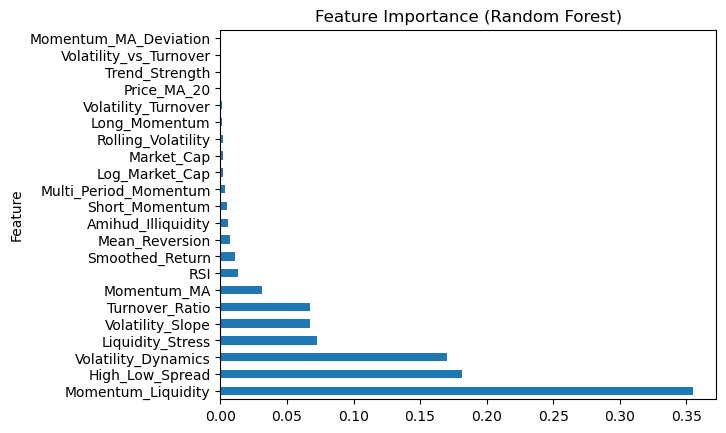

In [ ]:
# Correlation table with all factor included
import seaborn as sns
# Correlation matrix for features and target
correlation_matrix = train_data[final_features + ['ret']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature importance for Random Forest
rf_feature_importances = pd.DataFrame({
    'Feature': final_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(rf_feature_importances)

# Plot feature importances
rf_feature_importances.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance (Random Forest)")
plt.show()


In [ ]:
# Second Layer of Filtering
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from itertools import combinations

# Selected initial factors
initial_factors = [
    'Volatility_Dynamics', 'Mean_Reversion', 'Liquidity_Stress', 'RSI', 'Log_Market_Cap',
    'Volatility_Slope', 'Turnover_Ratio', 'Rolling_Volatility', 'Short_Momentum', 'High_Low_Spread',
    'Smoothed_Return', 'Long_Momentum', 'Momentum_MA', 'Market_Cap', 'Momentum_Liquidity',
    'Multi_Period_Momentum', 'Trend_Strength', 'Momentum_MA_Deviation', 'Price_MA_20', 'Amihud_Illiquidity',
    'Volatility_Turnover', 'Volatility_vs_Turnover'
]

# Correlation threshold
correlation_threshold = 0.75

# Calculate correlation matrix
correlation_matrix = sp500_full[initial_factors].corr().abs()

# Calculate correlation with target variable
target_correlation = sp500_full[initial_factors + ['ret']].corr()['ret'].abs().drop('ret')

# Remove high-correlation factors based on logic
selected_factors = set(initial_factors)

for factor_a in initial_factors:
    for factor_b in initial_factors:
        if factor_a != factor_b and factor_a in selected_factors and factor_b in selected_factors:
            if correlation_matrix.loc[factor_a, factor_b] > correlation_threshold:
                # Keep the factor with higher correlation to the target
                if target_correlation[factor_a] >= target_correlation[factor_b]:
                    selected_factors.discard(factor_a)
                else:
                    selected_factors.discard(factor_b)

low_corr_factors = list(selected_factors)
print(f"Factors after logical filtering: {len(low_corr_factors)} - {low_corr_factors}")

# Ensure X_train and X_test are pandas DataFrames
X_train = pd.DataFrame(X_train, columns=initial_factors)
X_test = pd.DataFrame(X_test, columns=initial_factors)

# Evaluate R² for all combinations of 10 factors
top_factors = []
top_r2_score = -np.inf

for factor_subset in combinations(low_corr_factors, 10):
    # Select only the columns corresponding to the factor subset
    X_train_subset = X_train[list(factor_subset)]
    X_test_subset = X_test[list(factor_subset)]

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=64, max_depth=15, random_state=42)
    rf_model.fit(X_train_subset, y_train)
    y_pred_rf = rf_model.predict(X_test_subset)
    rf_r2 = r2_score(y_test, y_pred_rf)

    # Update top factors
    if rf_r2 > top_r2_score:
        top_r2_score = rf_r2
        top_factors = factor_subset

print(f"Top 10 Factors: {top_factors}")
print(f"Top R² Score: {top_r2_score:.5f}")

In [ ]:
# Original Filtering After second layer


Forecasting Results:
Linear Regression    MSE: 0.00789, R²: 0.06009
Ridge Regression     MSE: 0.00826, R²: 0.01574
Random Forest        MSE: 0.00669, R²: 0.20307
Gradient Boosting    MSE: 0.00648, R²: 0.22819


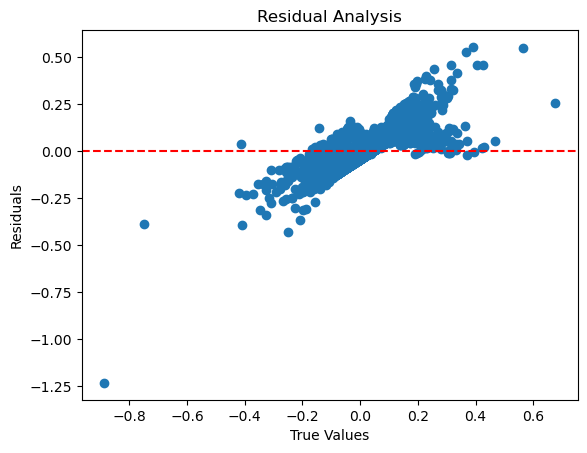

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
final_features = ['Volatility_Dynamics', 'Liquidity_Stress', 'RSI', 'Short_Momentum', 'High_Low_Spread', 'Smoothed_Return', 'Momentum_Liquidity', 'Long_Momentum', 'Amihud_Illiquidity']

# Train-Test Split
sp500_full = sp500_full.sort_values(by='date')
split_index = int(len(sp500_full) * 0.8)
train_data = sp500_full.iloc[:split_index]
test_data = sp500_full.iloc[split_index:]

X_train = train_data[final_features]
y_train = train_data['ret']
X_test = test_data[final_features]
y_test = test_data['ret']

# Ensure finite values in X and y
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

# --- Model Evaluation ---
forecasting_results = {}

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)
forecasting_results["Linear Regression"] = {
    "MSE": mean_squared_error(y_test, y_pred_lr),
    "R²": r2_score(y_test, y_pred_lr)
}

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
forecasting_results["Ridge Regression"] = {
    "MSE": mean_squared_error(y_test, y_pred_ridge),
    "R²": r2_score(y_test, y_pred_ridge)
}

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=5, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
forecasting_results["Random Forest"] = {
    "MSE": mean_squared_error(y_test, y_pred_rf),
    "R²": r2_score(y_test, y_pred_rf)
}

# Gradient Boosting
gbr_model = GradientBoostingRegressor(
    n_estimators=100, max_depth=3, random_state=42
)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)
forecasting_results["Gradient Boosting"] = {
    "MSE": mean_squared_error(y_test, y_pred_gbr),
    "R²": r2_score(y_test, y_pred_gbr)
}

# Display Results
print("\nForecasting Results:")
for model_name, metrics in forecasting_results.items():
    print(f"{model_name:20} MSE: {metrics['MSE']:.5f}, R²: {metrics['R²']:.5f}")

# Residual Analysis
y_pred_test = rf_model.predict(X_test)
residuals = y_test - y_pred_test
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()


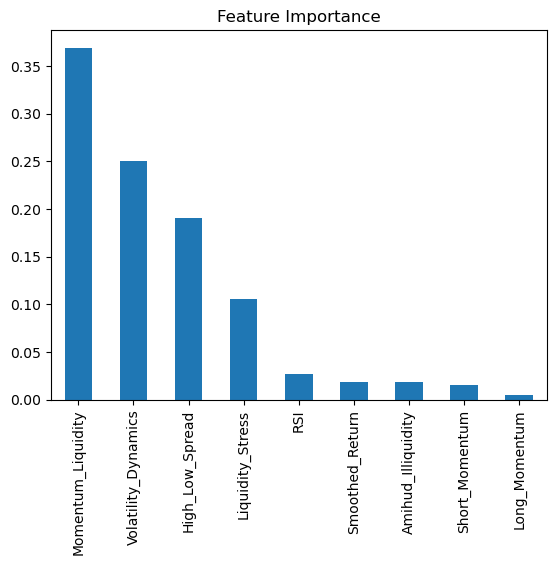

In [ ]:
feature_importances = pd.Series(rf_model.feature_importances_, index=final_features)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importance")
plt.show()


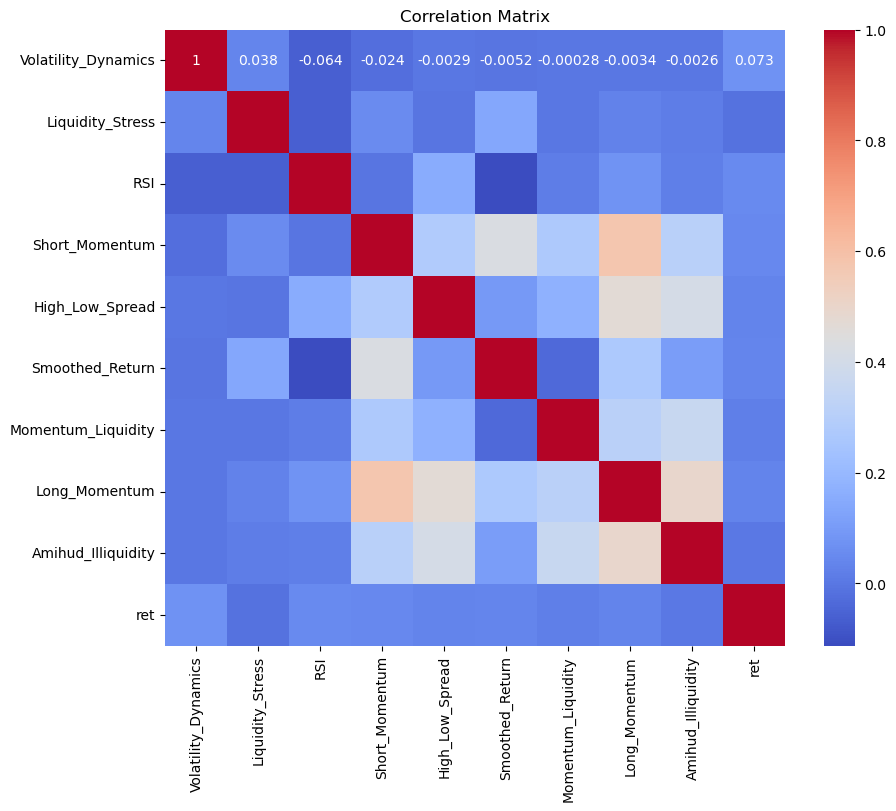

               Feature  Importance
6   Momentum_Liquidity    0.369288
0  Volatility_Dynamics    0.250619
4      High_Low_Spread    0.191050
1     Liquidity_Stress    0.105740
2                  RSI    0.027338
5      Smoothed_Return    0.018210
8   Amihud_Illiquidity    0.018119
3       Short_Momentum    0.015099
7        Long_Momentum    0.004536


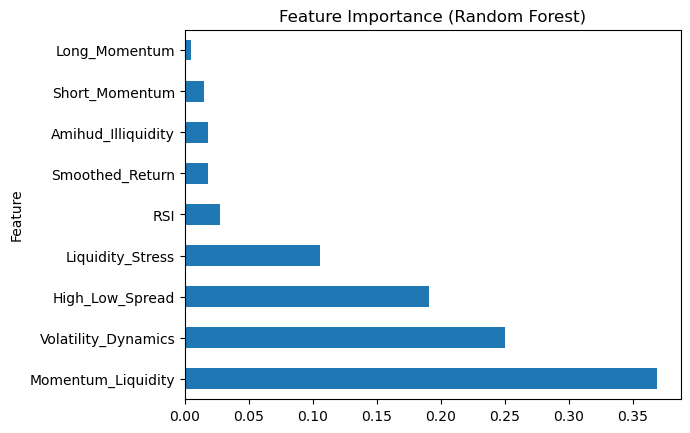

In [ ]:
import seaborn as sns
# Correlation matrix for features and target
correlation_matrix = train_data[final_features + ['ret']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature importance for Random Forest
rf_feature_importances = pd.DataFrame({
    'Feature': final_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(rf_feature_importances)

# Plot feature importances
rf_feature_importances.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance (Random Forest)")
plt.show()


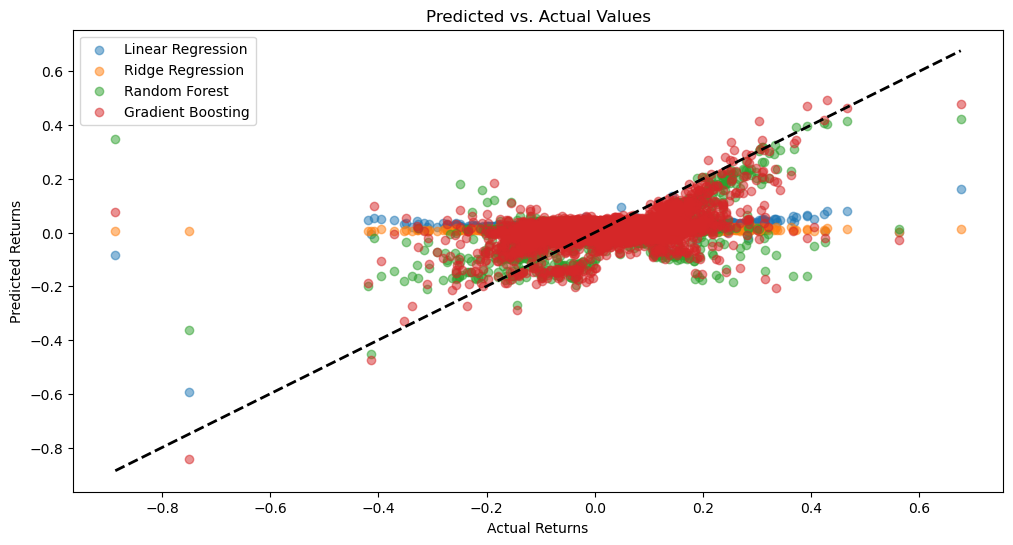

                        MSE        R²
Linear Regression  0.007886  0.060091
Ridge Regression   0.008259  0.015737
Random Forest      0.006687  0.203066
Gradient Boosting  0.006476  0.228186


In [ ]:
# Compare predicted vs actual values for each model
plt.figure(figsize=(12, 6))
for model_name, predictions in [
    ("Linear Regression", y_pred_lr),
    ("Ridge Regression", y_pred_ridge),
    ("Random Forest", y_pred_rf),
    ("Gradient Boosting", y_pred_gbr)
]:
    plt.scatter(y_test, predictions, label=model_name, alpha=0.5)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Predicted vs. Actual Values")
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.legend()
plt.show()

# Tabulated Results
results_df = pd.DataFrame(forecasting_results).T
print(results_df)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


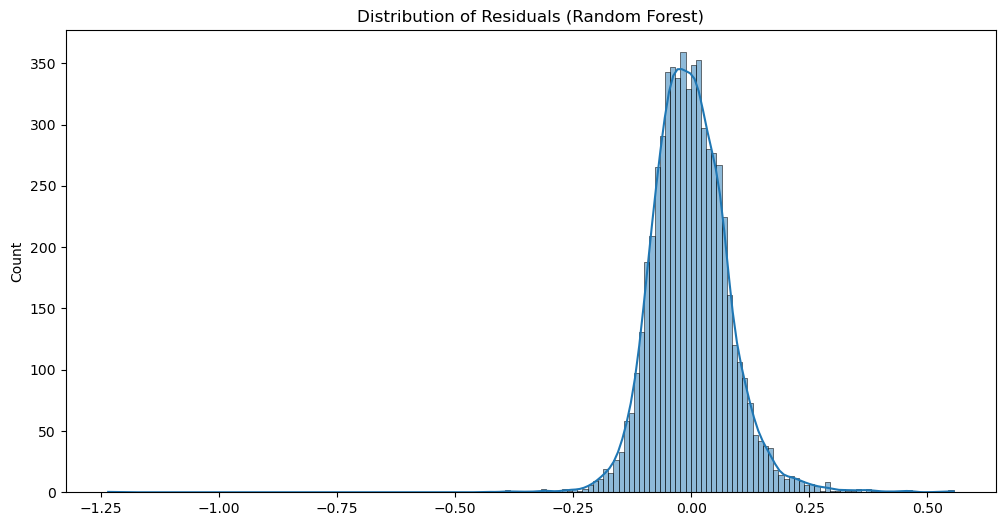

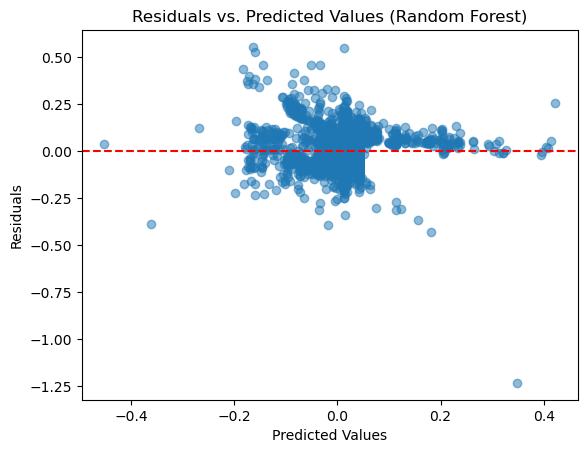

In [ ]:
# Residual analysis for Random Forest
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (Random Forest)")
plt.show()

plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values (Random Forest)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


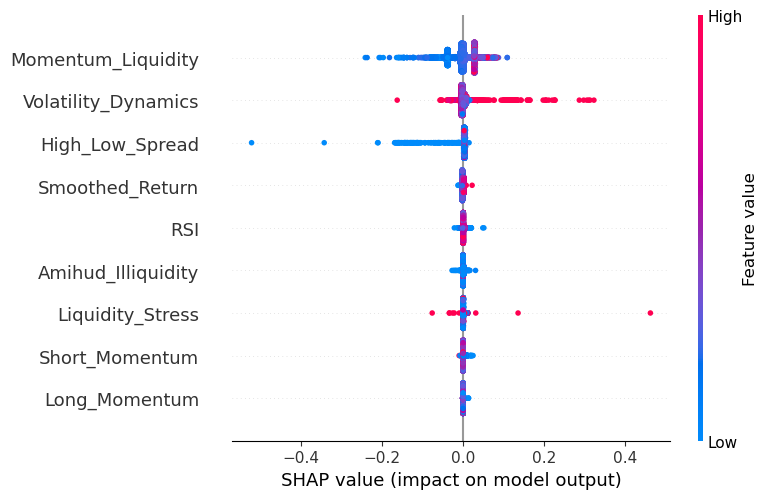

In [ ]:
# SHAP Analysis
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=final_features)


In [ ]:
# Backtesting

Backtesting Progress:   0%|                             | 0/168 [00:00<?, ?it/s]/var/folders/gf/ml7dm8wn2qn2k77q3vczgzw80000gn/T/ipykernel_68118/3844838069.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_window['predicted_returns'] = predicted_returns
Backtesting Progress:   1%|▏                    | 1/168 [00:04<11:45,  4.22s/it]/var/folders/gf/ml7dm8wn2qn2k77q3vczgzw80000gn/T/ipykernel_68118/3844838069.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_window['predicted_returns'] = predic

Sharpe Ratio: 0.25


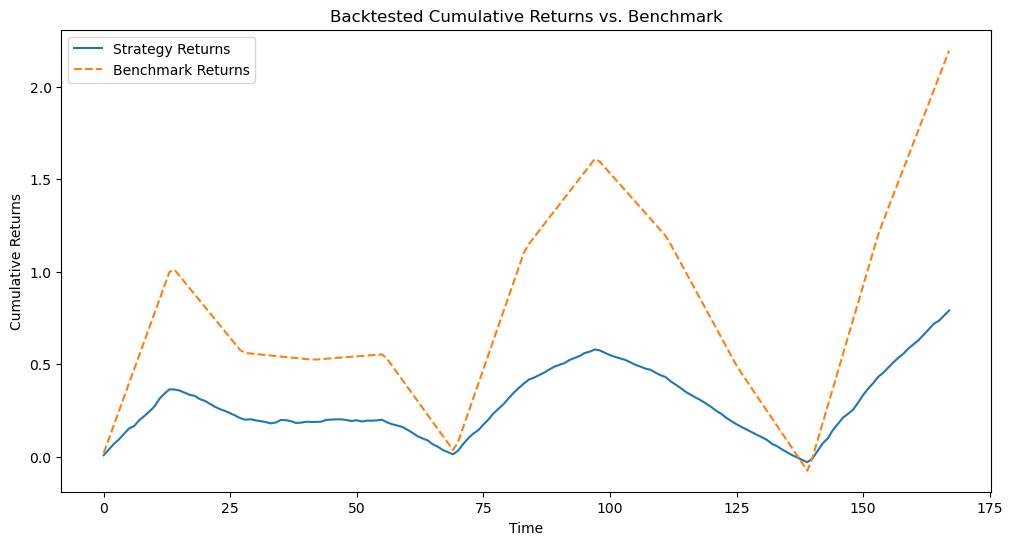

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


# Step 1: Define features and target
features = ['Volatility_Dynamics', 'Liquidity_Stress', 'RSI', 'Short_Momentum',
            'High_Low_Spread', 'Smoothed_Return', 'Momentum_Liquidity',
            'Long_Momentum', 'Amihud_Illiquidity']
target = 'ret'

# Step 2: Add benchmark data (equal-weighted as a proxy if no benchmark exists)
sp500_full['benchmark_ret'] = sp500_full.groupby('date')['ret'].transform('mean')

# Step 3: Sort data by date
sp500_full = sp500_full.sort_values(by='date')

# Step 4: Train-Test Split
train_size = int(len(sp500_full) * 0.8)
train_data = sp500_full.iloc[:train_size]
test_data = sp500_full.iloc[train_size:]

# Step 5: Rolling Window Backtest
window_size = 36
strategy_results = []
benchmark_results = []

for start in tqdm(range(0, len(test_data) - window_size, window_size), desc="Backtesting Progress"):
    end = start + window_size
    train_window = pd.concat([train_data, test_data.iloc[:start]])
    test_window = test_data.iloc[start:end]

    X_train = train_window[features]
    y_train = train_window[target]
    X_test = test_window[features]
    y_test = test_window[target]

    # Ensure no missing or infinite values
    X_train = np.nan_to_num(X_train)
    y_train = np.nan_to_num(y_train)
    X_test = np.nan_to_num(X_test)
    y_test = np.nan_to_num(y_test)

    # Train Gradient Boosting Model
    model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # Predict returns
    predicted_returns = model.predict(X_test)

    # Portfolio Simulation
    test_window['predicted_returns'] = predicted_returns
    test_window = test_window.sort_values(by='predicted_returns', ascending=False)
    top_n = 100  # Select top N stocks
    portfolio = test_window.head(top_n)

    portfolio_return = (portfolio['ret'] * (1 / top_n)).sum()
    strategy_results.append(portfolio_return)

    # Benchmark returns (average benchmark returns for the same period)
    benchmark_return = test_window['benchmark_ret'].mean()
    benchmark_results.append(benchmark_return)

# Step 6: Cumulative Returns
cumulative_strategy_returns = pd.Series(strategy_results).cumsum()
cumulative_benchmark_returns = pd.Series(benchmark_results).cumsum()

# Step 7: Sharpe Ratio
sharpe_ratio = np.mean(strategy_results) / np.std(strategy_results)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Step 8: Visualization
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
plt.plot(cumulative_benchmark_returns, label='Benchmark Returns', linestyle='--')
plt.title('Backtested Cumulative Returns vs. Benchmark')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean Return: 0.0047045051190476184
Std Dev Return: 0.01897260565243647


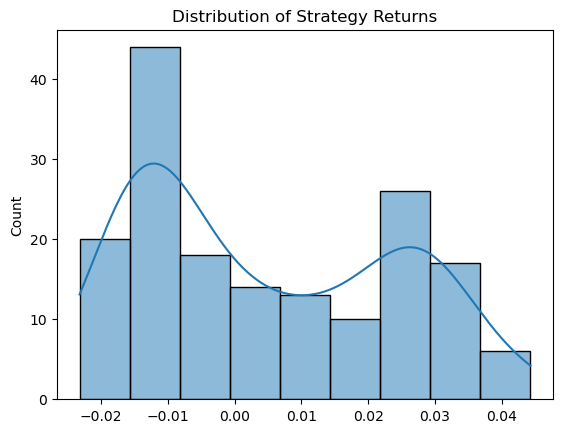

In [ ]:
import seaborn as sns
print(f"Mean Return: {np.mean(strategy_results)}")
print(f"Std Dev Return: {np.std(strategy_results)}")
sns.histplot(strategy_results, kde=True)
plt.title("Distribution of Strategy Returns")
plt.show()